# Combining Survey Responses With DB Target Data

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

import psycopg2

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, BaggingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import plot_partial_dependence

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLSResults
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style("white")

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 80)

## Data Cleaning & Feature Engineering

In [3]:
%pwd

'/Users/timothymiller/Galvanize/capstone_2_3/Vinyl_Me_Please/notebooks'

In [4]:
df = pd.read_csv('../../SENSITIVE/2019 Member Survey - Raw Data.csv', header=[0,1], low_memory=False)

In [5]:
df.shape

(6172, 454)

In [6]:
col_df = pd.DataFrame(df.columns.to_numpy().reshape([-1, 1]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 80):
    print(col_df)

                                                                                   0
0                                                (Respondent ID, Unnamed: 0_level_1)
1                                                 (Collector ID, Unnamed: 1_level_1)
2                                                   (Start Date, Unnamed: 2_level_1)
3                                                     (End Date, Unnamed: 3_level_1)
4                                                   (IP Address, Unnamed: 4_level_1)
5                                                (Email Address, Unnamed: 5_level_1)
6                                                   (First Name, Unnamed: 6_level_1)
7                                                    (Last Name, Unnamed: 7_level_1)
8                                                (Custom Data 1, Unnamed: 8_level_1)
9                                                       (How old are you?, Response)
10                                       (To what gender do you i

In [7]:
df.iloc[:, 421].value_counts()

Hardly ever               1887
Several times per week    1020
Every day                  623
About once a week          481
A few times a month        480
Every few months           391
Name: (Unnamed: 421_level_0, Play video games at home), dtype: int64

In [8]:
###---DONE---###

# col 415-421 Name: How often you do these things?
# df.iloc[:, 415].value_counts()

def col_how_often_do_encode(data_frame, col_idx_list):
    """ 
    Function to numerically encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as in the 'freq' dictionary below.
    """
    freq = {'Hardly ever': 0,
           'Every few months': 1,
           'A few times a month': 2,
           'About once a week': 3,
           'Several times per week': 4,
           'Every day': 5}
    
    for col_idx in col_idx_list:
        data_frame.iloc[:,col_idx].fillna("Hardly ever", inplace=True)
        data_frame.iloc[:,col_idx] = [freq[val] for val in data_frame.iloc[:,col_idx]]
    

In [9]:
###---DONE---###

# col 133 Name: How often do you use/interact with the following Vinyl Me, Please elements?
# df.iloc[:, 133].value_counts()
# 146

def col_how_much_use_encode(data_frame, col_idx_list):
    """ 
    Function to numerically encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as in the 'use' dictionary below.
    """
    use = {"I don't know about it": 0,
           "I don't care about it": 0,
           'Used it once': 1,
           'Sometimes': 2,
           'Frequently': 3}
    
    for col_idx in col_idx_list:
        data_frame.iloc[:,col_idx].fillna("I don't know about it", inplace=True)
        data_frame.iloc[:,col_idx] = [use[val] for val in data_frame.iloc[:,col_idx]]
    

In [10]:
###---DONE---###

# col 33 Name: (How long have you been buying records?, Response), dtype: float64 

def col_how_long_records_encode(data_frame, col_idx_list=[33]):
    """ 
    Function to numerically encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as in the 'length' dictionary below.
    """
    length = {'I just started': 0,
              '6 - 12 months': 0.5,
              '1-3 years': 1,
              '3-5 years': 1.5,
              '5-10 years': 2,
              '10-15 years': 2.5,
              'More than 15 years': 3}
    
    for col_idx in col_idx_list:
        data_frame.iloc[:,col_idx].fillna('I just started', inplace=True)
        data_frame.iloc[:,col_idx] = [length[val] for val in data_frame.iloc[:,col_idx]]

col_how_long_records_encode(df)
        
# def one_dim_scatterplot(data, ax, jitter=0.4, **options):
#     if jitter:
#         jitter = np.random.uniform(-jitter, jitter, size=data.shape)
#     else:
#         jitter = np.repeat(0.0, len(data))
#     ax.scatter(data, jitter, **options)
#     ax.yaxis.set_ticklabels([])
#     ax.set_ylim([-1, 1])

# fig, ax = plt.subplots(1, figsize=(16, 2))
# one_dim_scatterplot(df.iloc[:,34], ax, s=25, alpha=0.2)

In [11]:
###---DONE---###

# Encode col 34 About how many records do you own?
def encode_records_own(data_frame, col_idx=34):
    data_frame.iloc[:,col_idx].fillna(0, inplace=True)
    max_cutoff = np.percentile(data_frame.iloc[:,col_idx].to_numpy(), 90)
    data_frame.iloc[:,col_idx] = np.where(data_frame.iloc[:,col_idx] >= max_cutoff, 
                                          max_cutoff, data_frame.iloc[:,col_idx])
    data_frame.iloc[:,col_idx] = (data_frame.iloc[:,col_idx] / max_cutoff) * 5
    data_frame.iloc[:,col_idx] = data_frame.iloc[:,col_idx].apply(lambda x: int(x))

encode_records_own(df)

In [12]:
###---DONE---###

def col_binary_encode(data_frame, col_idx_list):
    """ 
    Function to binary encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as follows:
            'str(column title)' --> 1
            anything else       --> -1
    """
    for col_idx in col_idx_list:
        label = data_frame.columns.get_level_values(1)[col_idx]
        data_frame.iloc[:,col_idx] = data_frame.iloc[:,col_idx].apply(lambda x:
                                    1 if (str(x) == str(label)) | (x == 1) else -1)

In [13]:
df.head(5)

,Respondent ID,Collector ID,Start Date,End Date,IP Address,Email Address,First Name,Last Name,Custom Data 1,How old are you?,To what gender do you identify?,Unnamed: 11_level_0,Where do you live?,What is your living arrangement?,How many bedrooms are in your home?,With whom do you live? (best/closest description),Do you own/lease a vehicle?,On which social media platforms are you active? (check all that apply),Unnamed: 18_level_0,Unnamed: 19_level_0,Unnamed: 20_level_0,Unnamed: 21_level_0,Unnamed: 22_level_0,Unnamed: 23_level_0,Unnamed: 24_level_0,Unnamed: 25_level_0,Unnamed: 26_level_0,Unnamed: 27_level_0,Which VMP social accounts do you follow?,Unnamed: 29_level_0,Unnamed: 30_level_0,Unnamed: 31_level_0,Unnamed: 32_level_0,How long have you been buying records?,"About how many records do you own? (numbers only, ok to estimate)",Why did you start buying vinyl originally?,About how many records do you buy per month?,Have you ever inherited/been gifted a friend or family member's record collection?,Unnamed: 38_level_0,Unnamed: 39_level_0,Unnamed: 40_level_0,Unnamed: 41_level_0,Unnamed: 42_level_0,How often do you buy records from these places?,Unnamed: 44_level_0,Unnamed: 45_level_0,Unnamed: 46_level_0,Unnamed: 47_level_0,Unnamed: 48_level_0,Unnamed: 49_level_0,Unnamed: 50_level_0,Unnamed: 51_level_0,Unnamed: 52_level_0,Unnamed: 53_level_0,Unnamed: 54_level_0,Do you use Discogs?,How do you use Discogs? (check all that apply),Unnamed: 57_level_0,Unnamed: 58_level_0,Unnamed: 59_level_0,Unnamed: 60_level_0,How frequently do you use Discogs?,"How much money do you spend per month on music—shows, streaming, vinyl, merch, etc.?",How much do you agree with these statements?,Unnamed: 64_level_0,Unnamed: 65_level_0,Unnamed: 66_level_0,Unnamed: 67_level_0,Unnamed: 68_level_0,Unnamed: 69_level_0,Unnamed: 70_level_0,Unnamed: 71_level_0,Unnamed: 72_level_0,Unnamed: 73_level_0,Unnamed: 74_level_0,Unnamed: 75_level_0,Unnamed: 76_level_0,Unnamed: 77_level_0,Unnamed: 78_level_0,Unnamed: 79_level_0,Unnamed: 80_level_0,Unnamed: 81_level_0,Unnamed: 82_level_0,What do you enjoy doing most when listening to records?,How often do you listen to your record collection?,How many functional turntables do you have in your home?,What’s your main vinyl listening setup?,Unnamed: 87_level_0,Which is true regarding your primary turntable?,Where did you purchase your primary turntable?,Unnamed: 90_level_0,How much did you spend on your current (primary) vinyl setup?,"What percent of your home music listening is vinyl (vs. streaming/MP3s, CDs, etc)",What is the MAXIMUM quantity (total pressed) at which a release still feels limited or exclusive?,Why did you originally sign up for VMP?,"How did you first hear about Vinyl Me, Please?",Unnamed: 96_level_0,What has been your MOST played VMP record in the past 12 months?,What has been your LEAST played VMP record in the past 12 months?,How much do you agree with these statements?,Unnamed: 100_level_0,Unnamed: 101_level_0,Unnamed: 102_level_0,Unnamed: 103_level_0,Unnamed: 104_level_0,What is your preferred shipping method?,Unnamed: 106_level_0,How would you feel if we sent you a free vinyl record sponsored by a brand?,I would like to see more of this from VMP... (check all that apply),Unnamed: 109_level_0,Unnamed: 110_level_0,Unnamed: 111_level_0,Unnamed: 112_level_0,Unnamed: 113_level_0,Unnamed: 114_level_0,Unnamed: 115_level_0,Unnamed: 116_level_0,Unnamed: 117_level_0,Unnamed: 118_level_0,Unnamed: 119_level_0,Unnamed: 120_level_0,Do other people in your household regularly listen to records with you?,How likely is it that you would recommend this company to a friend or colleague?,"My favorite thing about Vinyl Me, Please is...","My LEAST favorite thing about Vinyl Me, Please is...",How satisfied are you with the following?,Unnamed: 126_level_0,Unnamed: 127_level_0,Unnamed: 128_level_0,Unnamed: 129_level_0,Unnamed: 130_level_0,Unnamed: 131_level_0,Unnamed: 132_level_0,"How often do you use/interact with the following

In [14]:
# Free-form text answer columns:
# Why did you start buying vinyl originally?
# What do you enjoy doing most when listening to records?
# Why did you originally sign up for VMP?
# What has been your MOST played VMP record in the past 12 months?
# What has been your LEAST played VMP record in the past 12 months?
# My favorite thing about Vinyl Me, Please is...
# My LEAST favorite thing about Vinyl Me, Please is...
# What is your favorite part of the VMP community?
# What would deepen your connection to the VMP Member community?


# Several "Other - please specify" columns.




In [15]:
###---DONE---###

# Col 9 - How old are you?
# df.iloc[:, 9].value_counts()

def col_age_encode(data_frame, col_idx_list=[9]):
    """ 
    Function to numerically encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as in the 'age' dictionary below.
    """
    age = {'Under 18': 0,
           '18-20': 0.5,
           '21-24': 1,
           '25-34': 1.5,
           '35-44': 2,
           '45-54': 2.5,
           '55-64': 3,
           '65+': 3.5}
    
    for col_idx in col_idx_list:
        data_frame.iloc[:,col_idx].fillna('25-34', inplace=True) # filling with most common
        data_frame.iloc[:,col_idx] = [age[val] for val in data_frame.iloc[:,col_idx]]

col_age_encode(df)

In [16]:
###---DONE---###

# Col 10 - To what gender do you identify?
# df.iloc[:, 10].value_counts()

def col_gender_encode(data_frame, col_idx_list=[10]):
    """ 
    Function to numerically encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as follows:
            Male          --> 1
            Female, Other --> 0
    """
    for col_idx in col_idx_list:
        data_frame.iloc[:,col_idx] = data_frame.iloc[:,col_idx].apply(lambda x:
                                    1 if (str(x) == 'Male') else 0)

col_gender_encode(df)

In [17]:
###---DONE---###

# Col 36 - About how many records do you buy per month?

def col_records_month_encode(data_frame, col_idx_list=[36]):
    """ 
    Function to numerically encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as in the 'record_nums' dictionary below.
            0 - 1         --> 0-1           --> 0
            3-Feb         --> 2-3           --> 1
            5-Apr         --> 4-5           --> 2
            10-Jun        --> 6-10          --> 3
            More than 10  --> More than 10  --> 4
    """
    record_nums = {'0 - 1': 0,
                   '3-Feb': 1,
                   '5-Apr': 2,
                   '10-Jun': 3,
                   'More than 10': 4}
    
    for col_idx in col_idx_list:
        data_frame.iloc[:,col_idx].fillna('0 - 1', inplace=True)
        data_frame.iloc[:,col_idx] = [record_nums[num] for num \
                                      in data_frame.iloc[:,col_idx]]

col_records_month_encode(df)

In [18]:
###---DONE---###

def col_satisfy_encode(data_frame, col_idx_list):
    """ 
    Function to numerically encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as in the 'sentiment' dictionary below.
    """
    sentiment = {'Very Satisfied': 2,
                 'Satisfied': 1,
                 'Neutral': 0,
                 'Dissatisfied': -1,
                 'Very Dissatsified': -2}
    
    for col_idx in col_idx_list:
        data_frame.iloc[:,col_idx].fillna('Neutral', inplace=True)
        data_frame.iloc[:,col_idx] = [sentiment[rating] \
                                      for rating in data_frame.iloc[:,col_idx]]

In [19]:
###---DONE---###

def col_agree_encode(data_frame, col_idx_list):
    """ 
    Function to numerically encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as in the 'sentiment' dictionary below.
    """
    sentiment = {'strongly agree': 2,
                 'agree': 1,
                 'neutral': 0,
                 'disagree': -1,
                 'strongly disagree': -2}
    
    for col_idx in col_idx_list:
        data_frame.iloc[:,col_idx].fillna('Neutral', inplace=True)
        data_frame.iloc[:,col_idx] = [sentiment[str(rating).lower()] \
                                      for rating in data_frame.iloc[:,col_idx]]

In [20]:
encode_col_list = list(range(17, 33))
col_binary_encode(df, encode_col_list)

In [21]:
agree_encode_col_list = list(range(63, 83))
col_agree_encode(df, agree_encode_col_list)

In [22]:
encode_col_list = list(range(108, 120))
col_binary_encode(df, encode_col_list)

In [23]:
satisfy_encode_col_list = list(range(125, 133))
col_satisfy_encode(df, satisfy_encode_col_list)

In [24]:
how_much_use_encode_list = list(range(133, 146))
col_how_much_use_encode(df, how_much_use_encode_list)

In [25]:
agree_encode_col_list = list(range(180, 217))
col_agree_encode(df, agree_encode_col_list)

In [26]:
encode_col_list = list(range(406, 414))
col_binary_encode(df, encode_col_list)

In [27]:
often_col_list = list(range(415, 422))
col_how_often_do_encode(df, often_col_list)

# Overall Population of Noobs

In [28]:
df.iloc[:, 33].value_counts()

3.0    1494
1.0    1204
2.0    1063
1.5     967
2.5     548
0.0     517
0.5     379
Name: (How long have you been buying records?, Response), dtype: int64

In [29]:
df_noobs = df[(df.iloc[:,33] <= 1)]

# df_noobs = df[(df.iloc[:,33] == 'I just started') 
#             | (df.iloc[:,33] == '6 - 12 months') 
#             | (df.iloc[:,33] == '1-3 years')]

print(f"length total: {len(df)}")
print(f"length noobs: {len(df_noobs)}")

length total: 6172
length noobs: 2100


# Switch Between All and Noobs

In [30]:
# removed gener - col 10

model_column_list = [5, 9, 12, 13, 16, 33, 34]
model_column_list = model_column_list + [i for i in range(63, 83)]
model_column_list = model_column_list + [i for i in range(108, 120)]
model_column_list = model_column_list + [i for i in range(125, 133)]
model_column_list = model_column_list + [i for i in range(133, 146)]
model_column_list = model_column_list + [i for i in range(180, 217)]
model_column_list = model_column_list + [i for i in range(406, 414)]
# model_column_list

df_model = df_noobs.iloc[:, model_column_list]
df_model.head(5)

,Email Address,How old are you?,Where do you live?,What is your living arrangement?,Do you own/lease a vehicle?,How long have you been buying records?,"About how many records do you own? (numbers only, ok to estimate)",How much do you agree with these statements?,Unnamed: 64_level_0,Unnamed: 65_level_0,Unnamed: 66_level_0,Unnamed: 67_level_0,Unnamed: 68_level_0,Unnamed: 69_level_0,Unnamed: 70_level_0,Unnamed: 71_level_0,Unnamed: 72_level_0,Unnamed: 73_level_0,Unnamed: 74_level_0,Unnamed: 75_level_0,Unnamed: 76_level_0,Unnamed: 77_level_0,Unnamed: 78_level_0,Unnamed: 79_level_0,Unnamed: 80_level_0,Unnamed: 81_level_0,Unnamed: 82_level_0,I would like to see more of this from VMP... (check all that apply),Unnamed: 109_level_0,Unnamed: 110_level_0,Unnamed: 111_level_0,Unnamed: 112_level_0,Unnamed: 113_level_0,Unnamed: 114_level_0,Unnamed: 115_level_0,Unnamed: 116_level_0,Unnamed: 117_level_0,Unnamed: 118_level_0,Unnamed: 119_level_0,How satisfied are you with the following?,Unnamed: 126_level_0,Unnamed: 127_level_0,Unnamed: 128_level_0,Unnamed: 129_level_0,Unnamed: 130_level_0,Unnamed: 131_level_0,Unnamed: 132_level_0,"How often do you use/interact with the following Vinyl Me, Please elements?",Unnamed: 134_level_0,Unnamed: 135_level_0,Unnamed: 136_level_0,Unnamed: 137_level_0,Unnamed: 138_level_0,Unnamed: 139_level_0,Unnamed: 140_level_0,Unnamed: 141_level_0,Unnamed: 142_level_0,Unnamed: 143_level_0,Unnamed: 144_level_0,Unnamed: 145_level_0,How much do you agree with these statements?,Unnamed: 181_level_0,Unnamed: 182_level_0,Unnamed: 183_level_0,Unnamed: 184_level_0,Unnamed: 185_level_0,Unnamed: 186_level_0,Unnamed: 187_level_0,Unnamed: 188_level_0,Unnamed: 189_level_0,Unnamed: 190_level_0,Unnamed: 191_level_0,Unnamed: 192_level_0,Unnamed: 193_level_0,Unnamed: 194_level_0,Unnamed: 195_level_0,Unnamed: 196_level_0,Unnamed: 197_level_0,Unnamed: 198_level_0,Unnamed: 199_level_0,Unnamed: 200_level_0,Unnamed: 201_level_0,Unnamed: 202_level_0,Unnamed: 203_level_0,Unnamed: 204_level_0,Unnamed: 205_level_0,Unnamed: 206_level_0,Unnamed: 207_level_0,Unnamed: 208_level_0,Unnamed: 209_level_0,Unnamed: 210_level_0,Unnamed: 211_level_0,Unnamed: 212_level_0,Unnamed: 213_level_0,Unnamed: 214_level_0,Unnamed: 215_level_0,Unnamed: 216_level_0,How do you watch TV at home? (select all that apply),Unnamed: 407_level_0,Unnamed: 408_level_0,Unnamed: 409_level_0,Unnamed: 410_level_0,Unnamed: 411_level_0,Unnamed: 412_level_0,Unnamed: 413_level_0
,Unnamed: 5_level_1,Response,Response,Response,Response,Response,Open-Ended Response,I consider myself a collector of things other than vinyl.,I usually listen to records alone.,I work in the music industry.,"When I purchase new vinyl, I always listen to it immediately (as soon as I can).",My record collection is an important conversation starter when people visit my home.,The quality of the vinyl package is more important than the music.,I assume that I’ll sell my vinyl collection one day.,I love teaching people about vinyl.,Most of my friends also collect vinyl.,I prefer buying new records over used records.,I usually listen to my VMP Records of the Month many times.,I listen to records only on the weekends.,I listen to vinyl at home more often than I stream music at home.,It’s important to me that my vinyl collection is in the center of my home.,I have a room in my home dedicated to vinyl listening.,I consider my vinyl collection as part of the main aesthetic of my home.,I prefer to stream an album before I choose to buy it on vinyl.,"My home design (furniture, art, etc.) is important to me.",It’s important to me that the records I buy are limited/exclusive.,I often will resell or “flip” my records.,Books,VMP merch,Band/artist merch,Concert ticket offerings,Events,Posters,Gear,How the records are made,Box sets,New release records,Classic records,45s,"Record of the Month (selection, package quality)","Add-on subscriptions (VMP Classics, VMP Rap & Hip-Hop)","Discovery (VMP Rising, On Rotation)","VMP Store (sele

In [31]:
df_model.iloc[:, 2].value_counts()

A city          1142
A suburb         598
A rural area     176
Name: (Where do you live? , Response), dtype: int64

In [32]:
# df_model = pd.concat([df_model, pd.get_dummies(df_model.iloc[:, 3])], axis=1)

In [33]:
# RUN LAST, WILL FLATTEN INDEX AND SHIFT COLUMN NUMBERS!

# Col 12 - Where do you live?
# Col 16 - Do you own/lease a vehicle?

# df.iloc[:, 12].value_counts()

dummy_df_where_live = pd.get_dummies(df_model.iloc[:, 2])
dummy_df_house = pd.get_dummies(df_model.iloc[:, 3])
dummy_df_car = pd.get_dummies(df_model.iloc[:, 4])

df_model = pd.concat([df_model, (dummy_df_where_live * 3)], axis=1)
df_model = pd.concat([df_model, (dummy_df_house * 3)], axis=1)
df_model = pd.concat([df_model, (dummy_df_car * 3)], axis=1)

df_model.drop(df_model.columns[[2, 3, 4]], axis=1, inplace=True)

In [34]:
df_model.shape

(2100, 113)

In [35]:
df_model.head(5)

,"(Email Address, Unnamed: 5_level_1)","(How old are you?, Response)","(How long have you been buying records?, Response)","(About how many records do you own? (numbers only, ok to estimate), Open-Ended Response)","(How much do you agree with these statements?, I consider myself a collector of things other than vinyl.)","(Unnamed: 64_level_0, I usually listen to records alone.)","(Unnamed: 65_level_0, I work in the music industry.)","(Unnamed: 66_level_0, When I purchase new vinyl, I always listen to it immediately (as soon as I can).)","(Unnamed: 67_level_0, My record collection is an important conversation starter when people visit my home.)","(Unnamed: 68_level_0, The quality of the vinyl package is more important than the music.)","(Unnamed: 69_level_0, I assume that I’ll sell my vinyl collection one day.)","(Unnamed: 70_level_0, I love teaching people about vinyl.)","(Unnamed: 71_level_0, Most of my friends also collect vinyl.)","(Unnamed: 72_level_0, I prefer buying new records over used records.)","(Unnamed: 73_level_0, I usually listen to my VMP Records of the Month many times.)","(Unnamed: 74_level_0, I listen to records only on the weekends.)","(Unnamed: 75_level_0, I listen to vinyl at home more often than I stream music at home.)","(Unnamed: 76_level_0, It’s important to me that my vinyl collection is in the center of my home.)","(Unnamed: 77_level_0, I have a room in my home dedicated to vinyl listening.)","(Unnamed: 78_level_0, I consider my vinyl collection as part of the main aesthetic of my home.)","(Unnamed: 79_level_0, I prefer to stream an album before I choose to buy it on vinyl.)","(Unnamed: 80_level_0, My home design (furniture, art, etc.) is important to me.)","(Unnamed: 81_level_0, It’s important to me that the records I buy are limited/exclusive.)","(Unnamed: 82_level_0, I often will resell or “flip” my records.)","(I would like to see more of this from VMP... (check all that apply), Books)","(Unnamed: 109_level_0, VMP merch)","(Unnamed: 110_level_0, Band/artist merch)","(Unnamed: 111_level_0, Concert ticket offerings)","(Unnamed: 112_level_0, Events)","(Unnamed: 113_level_0, Posters)","(Unnamed: 114_level_0, Gear)","(Unnamed: 115_level_0, How the records are made)","(Unnamed: 116_level_0, Box sets)","(Unnamed: 117_level_0, New release records)","(Unnamed: 118_level_0, Classic records)","(Unnamed: 119_level_0, 45s)","(How satisfied are you with the following?, Record of the Month (selection, package quality))","(Unnamed: 126_level_0, Add-on subscriptions (VMP Classics, VMP Rap & Hip-Hop))","(Unnamed: 127_level_0, Discovery (VMP Rising, On Rotation))","(Unnamed: 128_level_0, VMP Store (selection, price, shopping experience))","(Unnamed: 129_level_0, Content (The Magazine, podcast, The Standard))","(Unnamed: 130_level_0, Customer Service (response time, resolution of your issue))","(Unnamed: 131_level_0, Shipping speed (how quickly you receive your shipments))","(Unnamed: 132_level_0, Shipping service (package condition, order accuracy, tracking))","(How often do you use/interact with the following Vinyl Me, Please elements?, Rising)","(Unnamed: 134_level_0, Spotify playlists)","(Unnamed: 135_level_0, The Spins)","(Unnamed: 136_level_0, The Standard)","(Unnamed: 137_level_0, The online magazine)","(Unnamed: 138_level_0, VMP store exclusives)","(Unnamed: 139_level_0, Essentials Record of the Month)","(Unnamed: 140_level_0, Essentials cocktail recipe)","(Unnamed: 141_level_0, Essentials art print)","(Unnamed: 142_level_0, Rap & Hip Hop Record of the Month)","(Unnamed: 143_level_0, Rap & Hip Hop art stencil)","(Unnamed: 144_level_0, Classics Record of the Month)","(Unnamed: 145_level_0, Classics listening notes booklet)","(How much do you agree with these statements?, It’s important that my friends and significant other share my taste in music.)","(Unnamed: 181_level_0, I am always up-to-date on music trends.)","(Unnamed: 182_level_0, Curated playlists (by Spotify, Apple Music, etc.) are an important sourc

## Add Targets From Production DB

In [36]:
class CustomerStatus(object):

    def __init__(self):
        self.conn = psycopg2.connect(database="vinyl", user="postgres",
                                     host="localhost", port="5435")
        self.cur = self.conn.cursor()

        # PostgreSQL query to be run on Vinyl Me, Please database. Enclose in
        # triple quotes for psycopg2: ''' '''
        self.db_query = '''SELECT
                              customer_email,
                              total_lifetime_revenue,
                              primary_status
                           FROM
                              mailchimp_list_fields
                           WHERE
                               customer_created_at < '2019-10-01'::date;
                        '''

    # Run PostgreSQL query and return pandas DataFrame
    def get_customer_status(self):
        print("Executing query...")
        self.cur.execute(self.db_query)
        results = self.cur.fetchall()
        colnames = [desc[0] for desc in self.cur.description]
#         tuples = zip(colnames, colnames)
#         midx = pd.MultiIndex.from_tuples(tuples)
        self.df_status = pd.DataFrame(results, columns=colnames) #columns=colnames
        print("Query complete. Returned df_status.")
        return self.df_status, colnames

In [37]:
cs = CustomerStatus()
df_status, colnames = cs.get_customer_status()

Executing query...
Query complete. Returned df_status.


#### Counts of limited customers:

vinyl=# SELECT COUNT(*) FROM mailchimp_list_fields WHERE customer_created_at < '2019-09-01'::date;

147694

vinyl=# SELECT COUNT(*) FROM mailchimp_list_fields WHERE customer_created_at < '2019-10-01'::date;
150808


vinyl=# SELECT COUNT(*) FROM mailchimp_list_fields;
154857


In [38]:
154857 - 150808

4049

In [39]:
merged_df = pd.merge(df_status,
                     df_model,
                     left_on=df_status.iloc[:, 0],
                     right_on=df_model.iloc[:, 0],
                     how='inner')

In [40]:
merged_df.iloc[:, 3].value_counts()

cancelled    1075
active       1011
none            2
Name: primary_status, dtype: int64

In [41]:
def col_status_encode(data_frame, col_idx=3):
    """ 
    Function to binary encode the values in a pandas DataFrame column.

    Parameters: 
        col_idx_list (int): The index of the column to be encoded.
        data_frame: Name of the DataFrame containing the column in question.

    Returns: 
        DataFrame column with values encoded as follows:
            'str(column title)' --> 1
            anything else       --> -1
    """
    data_frame.iloc[:,col_idx] = data_frame.iloc[:,col_idx].apply(lambda x:
                                1 if str(x) == 'cancelled' else 0)

col_status_encode(merged_df, col_idx=3)

In [42]:
merged_df.head(15)

,key_0,customer_email,total_lifetime_revenue,primary_status,"(Email Address, Unnamed: 5_level_1)","(How old are you?, Response)","(How long have you been buying records?, Response)","(About how many records do you own? (numbers only, ok to estimate), Open-Ended Response)","(How much do you agree with these statements?, I consider myself a collector of things other than vinyl.)","(Unnamed: 64_level_0, I usually listen to records alone.)","(Unnamed: 65_level_0, I work in the music industry.)","(Unnamed: 66_level_0, When I purchase new vinyl, I always listen to it immediately (as soon as I can).)","(Unnamed: 67_level_0, My record collection is an important conversation starter when people visit my home.)","(Unnamed: 68_level_0, The quality of the vinyl package is more important than the music.)","(Unnamed: 69_level_0, I assume that I’ll sell my vinyl collection one day.)","(Unnamed: 70_level_0, I love teaching people about vinyl.)","(Unnamed: 71_level_0, Most of my friends also collect vinyl.)","(Unnamed: 72_level_0, I prefer buying new records over used records.)","(Unnamed: 73_level_0, I usually listen to my VMP Records of the Month many times.)","(Unnamed: 74_level_0, I listen to records only on the weekends.)","(Unnamed: 75_level_0, I listen to vinyl at home more often than I stream music at home.)","(Unnamed: 76_level_0, It’s important to me that my vinyl collection is in the center of my home.)","(Unnamed: 77_level_0, I have a room in my home dedicated to vinyl listening.)","(Unnamed: 78_level_0, I consider my vinyl collection as part of the main aesthetic of my home.)","(Unnamed: 79_level_0, I prefer to stream an album before I choose to buy it on vinyl.)","(Unnamed: 80_level_0, My home design (furniture, art, etc.) is important to me.)","(Unnamed: 81_level_0, It’s important to me that the records I buy are limited/exclusive.)","(Unnamed: 82_level_0, I often will resell or “flip” my records.)","(I would like to see more of this from VMP... (check all that apply), Books)","(Unnamed: 109_level_0, VMP merch)","(Unnamed: 110_level_0, Band/artist merch)","(Unnamed: 111_level_0, Concert ticket offerings)","(Unnamed: 112_level_0, Events)","(Unnamed: 113_level_0, Posters)","(Unnamed: 114_level_0, Gear)","(Unnamed: 115_level_0, How the records are made)","(Unnamed: 116_level_0, Box sets)","(Unnamed: 117_level_0, New release records)","(Unnamed: 118_level_0, Classic records)","(Unnamed: 119_level_0, 45s)","(How satisfied are you with the following?, Record of the Month (selection, package quality))","(Unnamed: 126_level_0, Add-on subscriptions (VMP Classics, VMP Rap & Hip-Hop))","(Unnamed: 127_level_0, Discovery (VMP Rising, On Rotation))","(Unnamed: 128_level_0, VMP Store (selection, price, shopping experience))","(Unnamed: 129_level_0, Content (The Magazine, podcast, The Standard))","(Unnamed: 130_level_0, Customer Service (response time, resolution of your issue))","(Unnamed: 131_level_0, Shipping speed (how quickly you receive your shipments))","(Unnamed: 132_level_0, Shipping service (package condition, order accuracy, tracking))","(How often do you use/interact with the following Vinyl Me, Please elements?, Rising)","(Unnamed: 134_level_0, Spotify playlists)","(Unnamed: 135_level_0, The Spins)","(Unnamed: 136_level_0, The Standard)","(Unnamed: 137_level_0, The online magazine)","(Unnamed: 138_level_0, VMP store exclusives)","(Unnamed: 139_level_0, Essentials Record of the Month)","(Unnamed: 140_level_0, Essentials cocktail recipe)","(Unnamed: 141_level_0, Essentials art print)","(Unnamed: 142_level_0, Rap & Hip Hop Record of the Month)","(Unnamed: 143_level_0, Rap & Hip Hop art stencil)","(Unnamed: 144_level_0, Classics Record of the Month)","(Unnamed: 145_level_0, Classics listening notes booklet)","(How much do you agree with these statements?, It’s important that my friends and significant other share my taste in music.)","(Unnamed: 181_level_0, I am always up-to-date on music trends.)","(Unnamed: 182_level_0, Curated playl

In [43]:
# print(merged_df.info(verbose=True, null_counts=True))

## MODELING

### Total Spending - Regression

In [44]:
# # Total Spending:
# y = merged_df.iloc[:, 2]
# X = merged_df.drop(merged_df.columns[[0, 1, 2, 3, 4]], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=42)

In [45]:
# X.head(5)

In [46]:
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X_train.to_numpy(), i)
#                      for i in range(X_train.shape[1])]
# vif["features"] = X_train.columns
# vif.round(1)

### Linear Regression

In [47]:
# linear_model = LinearRegression()
# linear_model.fit(X_train.to_numpy(), y_train.to_numpy());

In [48]:
# coef_df = pd.DataFrame({'Feature': vif["features"],
#                         'Sales Impact (# sold)': linear_model.coef_},
#                         index=None).round(0)

In [49]:
# coef_df.sort_values(by=['Sales Impact (# sold)'], ascending=False)

### Performing an Ordinary Least Squares Regression using the statsmodels Python package

In [50]:
# X_const = add_constant(X_train)
# est=sm.OLS(y_train, X_const)
# est = est.fit()
# # est.summary()

### Random Forest Regressor

In [51]:
# num_estimator_list = [1,2,5,10,20,40,100,500]
# train_errors_rf = []
# test_errors_rf = []

# for num_est in num_estimator_list:
#     rf = RandomForestRegressor(n_estimators = num_est, n_jobs=-1)
#     rf.fit(X_train, y_train)
#     y_pred_test =  rf.predict(X_test)
#     y_pred_train =  rf.predict(X_train)
    
#     train_errors_rf.append(mean_squared_error(y_pred_train, y_train)) 
#     test_errors_rf.append(mean_squared_error(y_pred_test, y_test))

In [52]:
# plt.figure(figsize=(15,10))
# plt.plot(num_estimator_list, train_errors_rf, label='Training MSE')
# plt.plot(num_estimator_list, test_errors_rf, label='Test MSE')
# plt.xlabel('Number of Estimators')
# plt.ylabel('MSE')
# plt.xscale('log')
# plt.title('Random Forest MSE vs. Num Estimators')
# plt.legend();

In [53]:
# rf = RandomForestRegressor(n_estimators = 40, n_jobs=-1)
# rf.fit(X_train, y_train)

# # feature_names = boston.feature_names[0:3]

In [54]:
# argsort = np.argsort(list(rf.feature_importances_))[::-1]

In [55]:
# features = vif["features"].to_list()

In [56]:
# ordered_features = [features[idx] for idx in argsort]
# ordered_features

In [57]:
# from sklearn import linear_model
# clf = linear_model.Lasso(alpha=0.1)
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)

# Account Status - Binary Classifier

In [58]:
# Account Status:
y = merged_df.iloc[:, 3]
X = merged_df.drop(merged_df.columns[[0, 1, 2, 3, 4]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [79]:
X_train.head(10)

,"(How old are you?, Response)","(How long have you been buying records?, Response)","(About how many records do you own? (numbers only, ok to estimate), Open-Ended Response)","(How much do you agree with these statements?, I consider myself a collector of things other than vinyl.)","(Unnamed: 64_level_0, I usually listen to records alone.)","(Unnamed: 65_level_0, I work in the music industry.)","(Unnamed: 66_level_0, When I purchase new vinyl, I always listen to it immediately (as soon as I can).)","(Unnamed: 67_level_0, My record collection is an important conversation starter when people visit my home.)","(Unnamed: 68_level_0, The quality of the vinyl package is more important than the music.)","(Unnamed: 69_level_0, I assume that I’ll sell my vinyl collection one day.)","(Unnamed: 70_level_0, I love teaching people about vinyl.)","(Unnamed: 71_level_0, Most of my friends also collect vinyl.)","(Unnamed: 72_level_0, I prefer buying new records over used records.)","(Unnamed: 73_level_0, I usually listen to my VMP Records of the Month many times.)","(Unnamed: 74_level_0, I listen to records only on the weekends.)","(Unnamed: 75_level_0, I listen to vinyl at home more often than I stream music at home.)","(Unnamed: 76_level_0, It’s important to me that my vinyl collection is in the center of my home.)","(Unnamed: 77_level_0, I have a room in my home dedicated to vinyl listening.)","(Unnamed: 78_level_0, I consider my vinyl collection as part of the main aesthetic of my home.)","(Unnamed: 79_level_0, I prefer to stream an album before I choose to buy it on vinyl.)","(Unnamed: 80_level_0, My home design (furniture, art, etc.) is important to me.)","(Unnamed: 81_level_0, It’s important to me that the records I buy are limited/exclusive.)","(Unnamed: 82_level_0, I often will resell or “flip” my records.)","(I would like to see more of this from VMP... (check all that apply), Books)","(Unnamed: 109_level_0, VMP merch)","(Unnamed: 110_level_0, Band/artist merch)","(Unnamed: 111_level_0, Concert ticket offerings)","(Unnamed: 112_level_0, Events)","(Unnamed: 113_level_0, Posters)","(Unnamed: 114_level_0, Gear)","(Unnamed: 115_level_0, How the records are made)","(Unnamed: 116_level_0, Box sets)","(Unnamed: 117_level_0, New release records)","(Unnamed: 118_level_0, Classic records)","(Unnamed: 119_level_0, 45s)","(How satisfied are you with the following?, Record of the Month (selection, package quality))","(Unnamed: 126_level_0, Add-on subscriptions (VMP Classics, VMP Rap & Hip-Hop))","(Unnamed: 127_level_0, Discovery (VMP Rising, On Rotation))","(Unnamed: 128_level_0, VMP Store (selection, price, shopping experience))","(Unnamed: 129_level_0, Content (The Magazine, podcast, The Standard))","(Unnamed: 130_level_0, Customer Service (response time, resolution of your issue))","(Unnamed: 131_level_0, Shipping speed (how quickly you receive your shipments))","(Unnamed: 132_level_0, Shipping service (package condition, order accuracy, tracking))","(How often do you use/interact with the following Vinyl Me, Please elements?, Rising)","(Unnamed: 134_level_0, Spotify playlists)","(Unnamed: 135_level_0, The Spins)","(Unnamed: 136_level_0, The Standard)","(Unnamed: 137_level_0, The online magazine)","(Unnamed: 138_level_0, VMP store exclusives)","(Unnamed: 139_level_0, Essentials Record of the Month)","(Unnamed: 140_level_0, Essentials cocktail recipe)","(Unnamed: 141_level_0, Essentials art print)","(Unnamed: 142_level_0, Rap & Hip Hop Record of the Month)","(Unnamed: 143_level_0, Rap & Hip Hop art stencil)","(Unnamed: 144_level_0, Classics Record of the Month)","(Unnamed: 145_level_0, Classics listening notes booklet)","(How much do you agree with these statements?, It’s important that my friends and significant other share my taste in music.)","(Unnamed: 181_level_0, I am always up-to-date on music trends.)","(Unnamed: 182_level_0, Curated playlists (by Spotify, Apple Music, etc.) are an important source of music discovery for me.)","(Unnam

In [60]:
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X_train.to_numpy(), i)
#                      for i in range(X_train.shape[1])]
# vif["features"] = X_train.columns
# vif.round(1)

In [61]:
### Account Status Prediction - Linear Model

In [62]:
# linear_model = LinearRegression()
# linear_model.fit(X_train.to_numpy(), y_train.to_numpy());

In [63]:
# coef_df = pd.DataFrame({'Feature': vif["features"],
#                         'Sales Impact (# sold)': linear_model.coef_},
#                         index=None).round(0)

In [64]:
# from sklearn.linear_model import LassoCV
# reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
# reg.score(X_test, y_test) 

## Random Forest Classifier

In [65]:
# num_estimator_list = [1,2,5,10,20,40,100,500]
# train_errors_rf = []
# test_errors_rf = []

# for num_est in num_estimator_list:
#     rf = RandomForestClassifier(n_estimators = num_est, n_jobs=-1)
#     rf.fit(X_train, y_train)
#     y_pred_test =  rf.predict(X_test)
#     y_pred_train =  rf.predict(X_train)
    
#     train_errors_rf.append(mean_squared_error(y_pred_train, y_train)) 
#     test_errors_rf.append(mean_squared_error(y_pred_test, y_test))

In [66]:
# plt.figure(figsize=(15,10))
# plt.plot(num_estimator_list, train_errors_rf, label='Training MSE')
# plt.plot(num_estimator_list, test_errors_rf, label='Test MSE')
# plt.xlabel('Number of Estimators')
# plt.ylabel('MSE')
# plt.xscale('log')
# plt.title('Random Forest MSE vs. Num Estimators')
# plt.legend();

In [67]:
# rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1)
# rf.fit(X_train, y_train)

# argsort = np.argsort(list(rf.feature_importances_))[::-1]

# features = vif["features"].to_list()
# ordered_features = [features[idx] for idx in argsort]
# ordered_features

# Adaboost Classifier

In [68]:
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')  # annoying warnings


# adaboost = AdaBoostClassifier(algorithm='SAMME.R',
#                               base_estimator=None,
#                               learning_rate=1.0,
#                               n_estimators=100,
#                               random_state=42)
# adaboost.fit(X_train, y_train)
# print("Accuracy:", adaboost.score(X_test, y_test), "\n")

# argsort = np.argsort(list(adaboost.feature_importances_))[::-1]

# features = vif["features"].to_list()
# ordered_features = [features[idx] for idx in argsort]
# pprint(ordered_features[:20])

In [69]:
def grid_search(X_train, y_train):
    ''' gets a rough idea where the best parameters lie '''
    # note that the number of estimators is set at 100 while the learning rate varies
    boosting_grid_rough = {'learning_rate': np.logspace(-3, 0, num = 4),
                           'n_estimators': [50, 100, 200, 500, 1000],
                           'random_state': [42]}
    
    coarse_search = GridSearchCV(AdaBoostClassifier(),
                                 boosting_grid_rough,
                                 scoring='f1',
                                 n_jobs=-1)
    print("Starting grid search - coarse (will take several minutes)")
    coarse_search.fit(X_train, y_train)
    coarse_params = coarse_search.best_params_
    coarse_score = coarse_search.best_score_
    print("Coarse search best parameters:")
    for param, val in coarse_params.items():
        print("{0:<20s} | {1}".format(param, val))
    print("Coarse search best score: {0:0.3f}".format(coarse_score))

    boosting_grid_fine_full_df = {'learning_rate': [1.0],
                                  'n_estimators': [250, 500, 750],
                                  'random_state': [42]}
    boosting_grid_fine_noobs_df = {'learning_rate': [0.05, 0.1, 0.15],
                                  'n_estimators': [150, 200, 250],
                                  'random_state': [42]}

    fine_search = GridSearchCV(AdaBoostClassifier(),
                               boosting_grid_fine_noobs_df,
                               scoring='f1',
                               n_jobs=-1)
    print("\nStarting grid search - fine")
    fine_search.fit(X_train, y_train)
    fine_params = fine_search.best_params_
    fine_score = fine_search.best_score_
    print("Fine search best parameters:")
    for param, val in fine_params.items():
        print("{0:<20s} | {1}".format(param, val))
    print("Fine search best score: {0:0.3f}".format(fine_score))
    model_best = fine_search.best_estimator_
    print("Returning best model.")
    return model_best


In [70]:
model_best = grid_search(X_train, y_train)

Starting grid search - coarse (will take several minutes)
Coarse search best parameters:
learning_rate        | 0.1
n_estimators         | 200
random_state         | 42
Coarse search best score: 0.625

Starting grid search - fine
Fine search best parameters:
learning_rate        | 0.05
n_estimators         | 200
random_state         | 42
Fine search best score: 0.627
Returning best model.


In [71]:
from sklearn.metrics import f1_score

y_pred = model_best.predict(X_test)
fscore = f1_score(y_test, y_pred)
print(f"F1 score on holdout set using best Adaboost model: {fscore:.3f}\n")

F1 score on holdout set using best Adaboost model: 0.671



In [72]:
# Train model using best params on whole data set 

final_model = AdaBoostClassifier(learning_rate=0.05,
                                 n_estimators=200,
                                 random_state=42)
final_model.fit(X, y)


feat_imp_argsort = np.argsort(list(final_model.feature_importances_))[::-1]
print(f"All sorted indicies: {feat_imp_argsort}")

unordered_feature_names = X.columns.to_list()
ordered_feature_names = [unordered_feature_names[idx] for idx in feat_imp_argsort]
number_features = 9

top_n_feature_indicies = feat_imp_argsort[:number_features]
top_n_feature_names = ordered_feature_names[:number_features]

print(f"\nTop {number_features} features:")
print(f"Indicies: {top_n_feature_indicies}\n")
pprint(top_n_feature_names)

All sorted indicies: [  0  35  90  49  55   2  15  83 109  48  13  87 108  60  54  82  36  20
  43  62  68  85  86  75  17  58  45  12  80  67  18  37  38  39  34  40
  41  42  33  32  31  30 106  23  29  28   1   3   4   5   6   7   8   9
  10  11  14  16  19  21  22  24  25  26  27  44  53  46  78  81  84  88
  89 107  91  92  93  94  95  96  97  98  99 100 101 102 103 104  79  77
  47  76  50  51  52 105 110  56  57  59  61  63  64  65  66  69  70  71
  72  73  74 111]

Top 9 features:
Indicies: [  0  35  90  49  55   2  15  83 109]

[('How old are you?', 'Response'),
 ('How satisfied are you with the following?',
  'Record of the Month (selection, package quality)'),
 ('Unnamed: 214_level_0',
  'I have to hear an album before I’d ever purchase it.'),
 ('Unnamed: 139_level_0', 'Essentials Record of the Month'),
 ('Unnamed: 145_level_0', 'Classics listening notes booklet'),
 ('About how many records do you own? (numbers only, ok to estimate)',
  'Open-Ended Response'),
 ('Unnamed: 75

In [73]:
imp_nums = final_model.feature_importances_
imp_nums_sort = [imp_nums[idx] for idx in feat_imp_argsort][:number_features]
imp_nums_sort = imp_nums_sort / max(imp_nums_sort)
imp_nums_sort = imp_nums_sort * 100
imp_nums_sort

array([100.        , 100.        ,  66.66666667,  58.33333333,
        50.        ,  41.66666667,  41.66666667,  37.5       ,
        37.5       ])

In [74]:
custom_feature_names = X.columns.to_list()
custom_feature_names[0] = 'Age'
custom_feature_names[35] = 'Record of the Month satisfaction'
custom_feature_names[90] = 'Must hear album before purchasing'
custom_feature_names[49] = 'How often Essentials Record of the Month'
custom_feature_names[109] = 'I do not own or lease a vehicle'
custom_feature_names[58] = 'Curated playlists for music discovery'
custom_feature_names[17] = 'Have dedicated vinyl listening room'
custom_feature_names[36] = 'Add-on subscriptions satisfaction'
custom_feature_names[60] = 'Know everything about favorite artists'
custom_feature_names[55] = 'How often Classics listening notes booklet'
custom_feature_names[2] = 'How many records do you own?'
custom_feature_names[15] = 'Listen to vinyl more than stream music'
custom_feature_names[83] = 'I buy everything my favorite artists release'


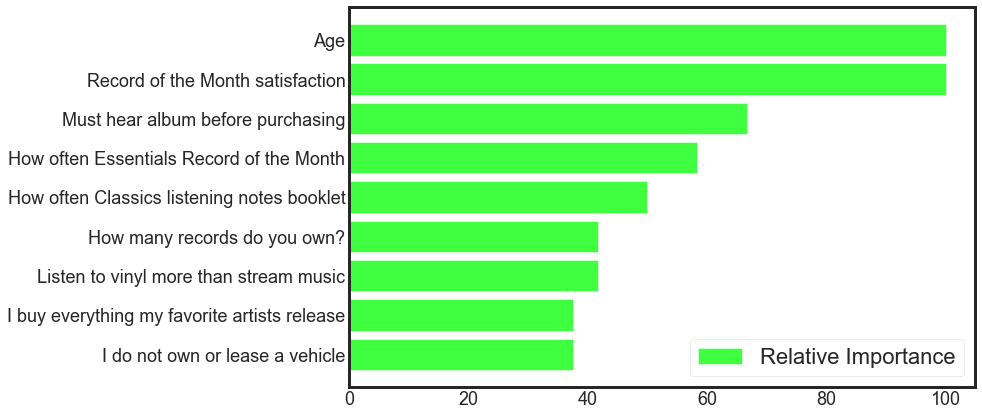

In [80]:
x_bar = [custom_feature_names[idx] for idx in feat_imp_argsort][:number_features]
fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')
plt.barh(x_bar, imp_nums_sort, color='#40FF40')
plt.xticks(rotation='0', fontsize=18)
# plt.title("Top Feature Importances", fontsize=22)
plt.yticks(fontsize=18)
ax.legend(['Relative Importance'], fontsize=22)
# ax.set_facecolor('whitesmoke')
ax.invert_yaxis()


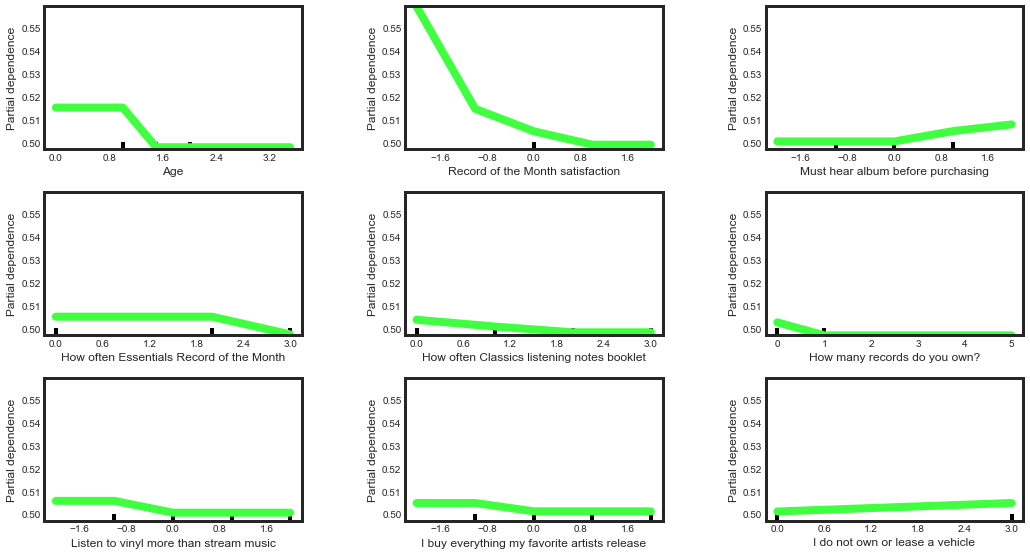

In [81]:
# Partial Dependence Plots

fig, ax = plt.subplots(figsize=(16, 13), facecolor='white')
# plt.title("Top Features Partial Dependence Plots", fontsize='large')
plot_partial_dependence(final_model,
                        X_train,
                        top_n_feature_indicies,
                        feature_names=custom_feature_names,
                        fig=fig,
                        line_kw={'c': '#40FF40', 'linewidth': 8},
                        n_jobs=-1)
# plt.subplots_adjust(top=0.9)


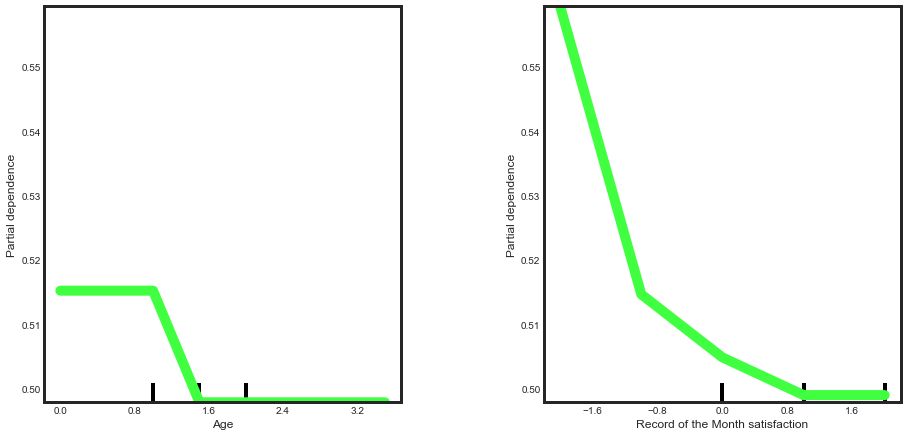

In [82]:
# Single Partial Dependence Plot

fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')
plt.title("Top Features Partial Dependence Plots", fontsize='large')
ax.set_facecolor('whitesmoke')
plot_partial_dependence(final_model,
                        X_train,
                        [0, 35],
                        feature_names=custom_feature_names,
                        fig=fig,
                        line_kw={'c': '#40FF40', 'linewidth': 10},
                        n_jobs=-1)
